In [40]:
import pylab as pl

import jax.numpy as np
from numpy.random import randn
import pytest
from numpy.testing import assert_allclose
from jax import random

from jaxrk.rkhs import CovOp, Cdo, Cmo, FiniteOp, FiniteVec, multiply, inner, SpVec, CombVec
from jaxrk.kern import (GaussianKernel, SplitDimsKernel, PeriodicKernel)
from jaxrk.utilities.array_manipulation import all_combinations
from sklearn.datasets import make_moons

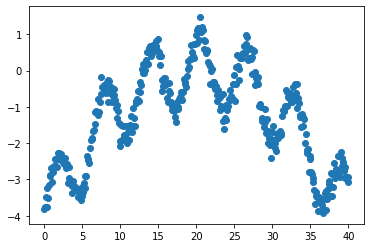

In [41]:
x = np.linspace(0, 40, 400).reshape((-1, 1))
y = np.sin(x) -(0.1*(x-20))**2 + randn(len(x)).reshape((-1, 1)) * 0.2
out_kern = GaussianKernel(0.5)

pl.scatter(x.T, y.T)

In [42]:
spv = SpVec(out_kern, np.hstack((x, y)), np.array([len(x)]), use_subtrajectories = True)

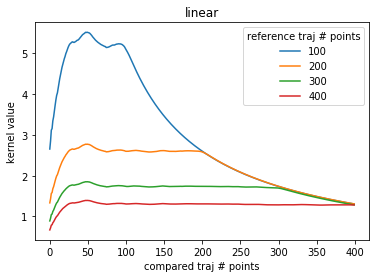

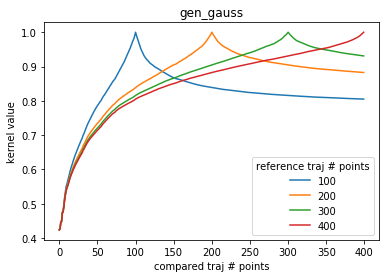

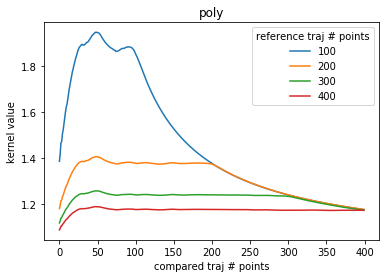

In [55]:
for dist in ("linear", "gen_gauss", "poly"):
    spv.use_inner = dist
    inn = spv.inner()
    pl.figure()
    for i in range(100, 401, 100):
        pl.plot(inn[i], label=str(i))
    pl.legend(loc="best", title="reference traj # points")
    pl.title(dist)
    pl.xlabel("compared traj # points")
    pl.ylabel("kernel value")

In [44]:
def plot_pred(mean_var, x, y, points_per_split = 1):
    if points_per_split == 1:
        rep_x = x
    else:
        rep_x = np.repeat(x, points_per_split, axis=0)
        
    pl.plot(x[200:].flatten(), mean_var.T[0].flatten(), color="red")
    pl.scatter(rep_x.T[:200], y.T[:200 * points_per_split].flatten(), color="green")
    pl.scatter(rep_x.T[200:], y.T[200 * points_per_split:].flatten(), color="green")
    sd = np.sqrt(mean_var.T[1].flatten())
    pl.fill_between(x[200:].flatten(), mean_var.T[0].flatten() + sd, mean_var.T[0].flatten() - sd, color="red", alpha=0.2)


In [45]:
refervec = FiniteVec(out_kern, np.linspace(y.min() - 4, y.max() + 4, 6000)[:, None])
invec_gg = SpVec(out_kern, np.hstack((x[:-1], y[:-1])), np.array([len(x) - 1]), use_subtrajectories = True, use_inner="gen_gauss")
invec_lin = SpVec(out_kern, np.hstack((x[:-1], y[:-1])), np.array([len(x) - 1]), use_subtrajectories = True, use_inner="linear")
invec_pol = SpVec(out_kern, np.hstack((x[:-1], y[:-1])), np.array([len(x) - 1]), use_subtrajectories = True, use_inner="poly")
outvec = FiniteVec(out_kern, y[1:])

Text(0.5, 1.0, 'Generalized gaussian kernel on process embeddings')

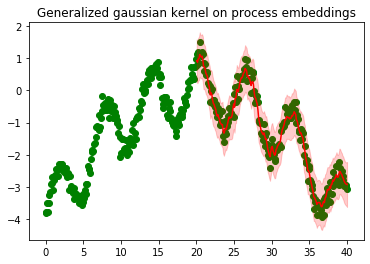

In [46]:
cd_gg = Cdo(invec_gg, outvec, refervec)
mean_var_gg = np.array(multiply(cd_gg, invec_gg).normalized().get_mean_var()).T
plot_pred(mean_var_gg[199:], x, y)
pl.title("Generalized gaussian kernel on process embeddings")

Text(0.5, 1.0, 'Linear kernel on process embeddings')

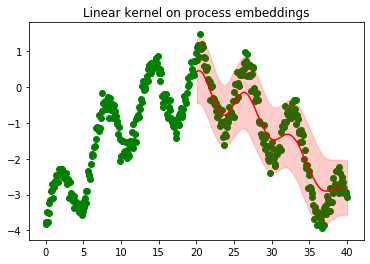

In [57]:
cd_lin = Cdo(invec_lin, outvec, refervec)
mean_var_lin = np.array(multiply(cd_lin, invec_lin).normalized().get_mean_var()).T
plot_pred(mean_var_lin[199:], x, y)
pl.title("Linear kernel on process embeddings")

Text(0.5, 1.0, 'Polynomial kernel on process embeddings')

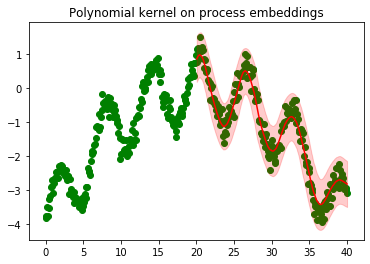

In [48]:
cd_pol = Cdo(invec_pol, outvec, refervec)
mean_var_pol = np.array(multiply(cd_pol, invec_pol).normalized().get_mean_var()).T
plot_pred(mean_var_pol[199:], x, y)
pl.title("Polynomial kernel on process embeddings")